# GP regression 1D toy example

This notebooks demonstrates a simple toy application of GP regression, using five samples taken from an analytic test function. The GP is fit by maximum likelihood, the code is implemented in the `GPmodule`.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal, invgamma, beta
from matplotlib import pyplot as plt
import GPmodule

## Generate sample data

Set the sample locations (`x`), here we chose five uniformly spaced points. Define the toy function we are trying to emulate, $f(x) = x \sin (x)$.

In [2]:
x = np.vstack(np.linspace(1/8, 7/8, 5))
xpred = np.vstack(np.linspace(0, 1, 51))

# Define a toy function we want to emulate - we don't usually know this true generating process
f = lambda x: x*np.sin(2*np.pi*x)

# Data
y = f(x)

## Fit the GP by maximizing the likelihood

Fit the model using the machinery of `GPmodule`. The GP is fit by maximizing the likelihood function (more properly, by minimizing the negative log-marginal likelihood). We also compute the  standard error estimate to add to the plots

In [3]:
GPmodel = GPmodule.GP(covariance=GPmodule.squared_exponential, cov_para={'nugget':1e-3})
x0 = np.array([1, 0.5]) # Initial GP hyperparameter estimate (variance, length scale) for optimization
fit_maxl = GPmodel.fit(x, y, x0)
print(GPmodel.minimize_res)
ypred = GPmodel.predictor(xpred)
epred = GPmodel.error(xpred)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.989954265337257
       x: [ 4.093e-01  2.270e-01]
     nit: 13
     jac: [-6.978e-03 -4.732e-03]
    nfev: 50
    njev: 13


Text(0.5, 1.0, 'GP predictions')

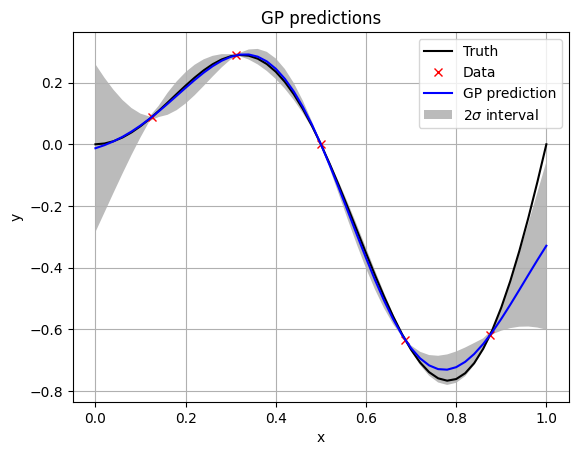

In [9]:
fig, ax = plt.subplots()
ax.plot(xpred, f(xpred), color='k', label='Truth')
ax.plot(x, y, linestyle='', marker='x', color='red', label='Data')
ax.plot(xpred, ypred, color='blue', label='GP prediction')
ax.fill_between(xpred.flatten(), ypred-2*epred, ypred+2*epred, 
    color='#bbbbbb', alpha=1., label='$2\sigma$ interval', zorder=0,
    edgecolor='none')
ax.legend(loc='upper right')
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('GP predictions')

Text(0.5, 1.0, 'GP prediction error')

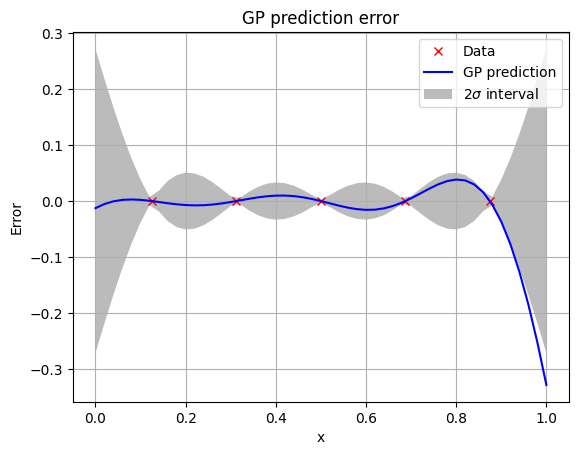

In [10]:
fig, ax = plt.subplots()
ax.plot(x, y-y, linestyle='', marker='x', color='red', label='Data')
ax.plot(xpred, ypred - f(xpred).flatten(), color='blue', label='GP prediction')
ax.fill_between(xpred.flatten(), -2*epred, 2*epred, 
    color='#bbbbbb', alpha=1.0, label='$2\sigma$ interval', zorder=0,
    edgecolor='none')
ax.legend(loc='upper right')
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('Error')
ax.set_title('GP prediction error')

## What is really going on with the 2$\sigma$ intervals?

The shaded 2$\sigma$ intervals above are computed from the exact posterior distribution. We can see this nicely if we draw samples from the posterior distribution and compare them to the 2$\sigma$ intervals. For reference, we will also add random samples from the prior distribution of GPs with random variances and length scales.

The prior distributions have zero mean and covariance given by the squared exponential function with the given length scale and variance. For prediction locations $x_p$, the posterior distribution has mean
$$\mu_{\rm{post}} = K(x_p, x) K(x, x)^{-1} y$$
and covariance
$$\Sigma_{\rm{post}} = K(x_p, x_p) - K(x_p, x) K(x, x)^{-1} K(x_p, x)^T$$
where we use the maximum likelihood estimates for the GP variance and length scale.

Kp.shape (51, 51)
Kvec.shape (51, 5)
K.shape (5, 5)
y.shape
(51, 1)
(51, 51)


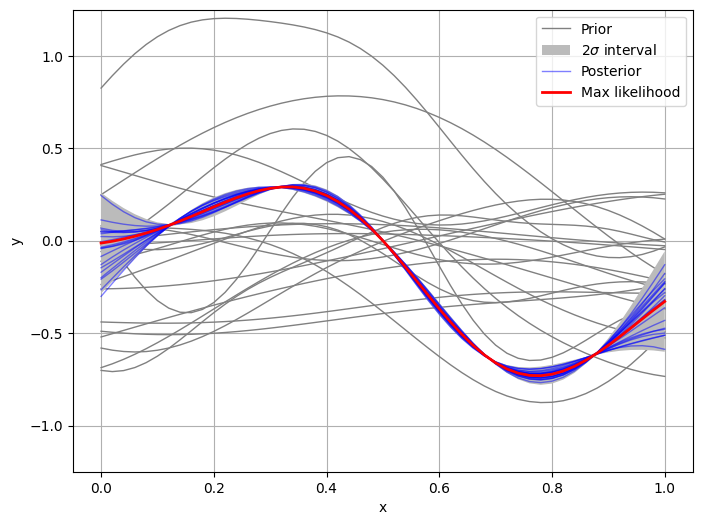

In [24]:
prior_mean = np.zeros(y.shape)
prior_cov = GPmodel.K

Kvec = GPmodel.covariance(xpred, x, GPmodel.theta)
Kp = GPmodel.covariance(xpred, xpred, GPmodel.theta)
print('Kp.shape', Kp.shape)
print('Kvec.shape', Kvec.shape)
print('K.shape', prior_cov.shape)
print('y.shape')
post_mean =  Kvec @ GPmodel.K_inv @ y
post_cov = Kp - Kvec @ GPmodel.K_inv @ Kvec.T

print(post_mean.shape)
print(post_cov.shape)

prior = beta(5, 10)
prior2 = beta(5, 10)

n_samples = 20
prior_samples = np.zeros((n_samples, len(xpred)))
for i in range(n_samples):
    vari = prior.rvs(size=1)
    lsi = prior2.rvs(size=1)
    thetai = np.array([vari, lsi])
    prior_dist = multivariate_normal(cov=GPmodel.covariance(xpred, xpred, thetai), allow_singular=True)
    prior_samples[i, :] = prior_dist.rvs(size=1)

post_dist = multivariate_normal(mean=post_mean.flatten(), cov=post_cov, allow_singular=True)
post_samples = post_dist.rvs(size=n_samples)

fig, ax = plt.subplots(figsize=(8, 6))
prior_handles = ax.plot(xpred, prior_samples.T, color='gray', linewidth=1., label='Prior samples')

sigma_handle = ax.fill_between(xpred.flatten(), ypred-2*epred, ypred+2*epred, 
    color='#bbbbbb', alpha=1., label='$2\sigma$ interval',
    edgecolor='none', zorder=10)

post_handles = ax.plot(xpred, post_samples.T, color='blue', linewidth=1., zorder=10, alpha=0.5, label='Posterior samples')
ml_handle, = ax.plot(xpred, ypred, color='red',
   linewidth=2, zorder=11, label='Max likelihood')

ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim([-1.25, 1.25])
ax.legend([prior_handles[0], sigma_handle, post_handles[0], ml_handle], ['Prior', '2$\sigma$ interval', 'Posterior', 'Max likelihood'], 
          loc='upper right', markerscale=10)
# leg = ax.legend(loc='upper right')

This example is a hint at what is to come with the fully Bayesian GP treatment. For a Bayesian GP, we treat the GP hyperparameters as unknown and explore the complete distribution with MCMC. This can be visualized as imagining computing the likelihood function for each of the grey prior samples in the above figure, multiplying by the priors, and selecting the most likely candidates.